# Parameters

In [2]:
# Choose model checkpoint
# NOTE: make sure CHOSEN_MODEL_CKPT exists in `model_configs` below

# CHOSEN_MODEL_CKPT = 'siamese_contrastive.pt'
# CHOSEN_MODEL_CKPT = 'siamese_contrastive_7k.pt'
# CHOSEN_MODEL_CKPT = 'siamese_contrastive_test-f1=0.301_splitting-by-query_cc12m_rubert_tiny_ep_1.pt'
CHOSEN_MODEL_CKPT = 'siamese_contrastive_soft-neg_epoch=1_val-f1=0.829_val-pos-acc=0.802_val-neg-acc=0.932_splitting-by-query_cc12m_rubert_tiny_ep_1.pt_best-f1-threshold=1.010.pt'

In [3]:
DATA_PATH = 'data/'

NAMES_AS_DESCRIPTIONS = False
IMG_DATASET_NAME = 'images_OZ_geo_5500'
EMBEDDINGS_FILE_NAME = 'embeddings/OZ_geo_5500/siamese-embeddings_num-rows=5562.parquet'
PAIRWISE_MAPPING_FILE_NAME = 'tables_OZ_geo_5500/processed/regex-pairwise-groups/regex-pairwise-groups_num-queries=20_patterns-dict-hash=a6223255f273e52a893ba7235e3c19b3/mapping.parquet'
SOURCE_FILEPATH = 'tables_OZ_geo_5500/processed/OZ_geo_5500.csv'
QUERY_SELLER = 'ИНТЕРТРЕЙД'

In [4]:
import torch

DEVICE='cuda' if torch.cuda.is_available() else 'cpu'
BATCH_SIZE = 768 if torch.cuda.is_available() else 8
LIMIT_PAIRS = None if torch.cuda.is_available() else 6

# Log into services

In [5]:
try:
    import dotenv
except ImportError:
    !pip install python-dotenv

In [6]:
# Use tokens from .env

import os
from dotenv import load_dotenv

import huggingface_hub
import wandb

load_dotenv()

HF_TOKEN = os.getenv("HF_TOKEN")
huggingface_hub.login(token=HF_TOKEN)

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


# Imports

In [7]:
import os
# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"] = "1"


from timm import create_model
import numpy as np
import pandas as pd
import os
import torch
from torch import nn
from torch import optim, Tensor
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms
# from torchinfo import summary
import transformers
from transformers import DistilBertModel, DistilBertConfig, DistilBertTokenizer,\
        get_linear_schedule_with_warmup
from transformers import AutoModel, AutoTokenizer

import cv2

from PIL import Image
from tqdm.auto import tqdm

import json
from itertools import product

# import datasets
# from datasets import Dataset, concatenate_datasets
import argparse
import requests

from io import BytesIO
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, f1_score
import matplotlib.pyplot as plt
import more_itertools

# Evaluation loop

## Run evaluation

In [8]:
# Download models' weights & text/image datasets

from huggingface_hub import snapshot_download
from pathlib import Path

REPO_ID = "INDEEPA/clip-siamese"

# Download all files which are not None (ckpt & img always)
allow_patterns = [
    f"train_results/{CHOSEN_MODEL_CKPT}",
    f"{IMG_DATASET_NAME}.zip",
]

# Add other files if not None
for f in [EMBEDDINGS_FILE_NAME, SOURCE_FILEPATH, PAIRWISE_MAPPING_FILE_NAME]:
    if f is not None:
        allow_patterns.append(f)

snapshot_download(
    repo_id=REPO_ID,
    repo_type='dataset',
    local_dir='data',
    allow_patterns=allow_patterns,
)

!unzip -n -q data/{IMG_DATASET_NAME}.zip -d data/

Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

In [9]:
emb_table = pd.read_parquet(DATA_PATH + EMBEDDINGS_FILE_NAME)   
emb_table.head()

,sku,siamese_emb
0,1871769771,"[-0.36614302, 0.025540195, 0.0073242486, -0.06..."
1,1679550303,"[-0.28556544, 0.037392754, -0.13363522, -0.022..."
2,1200553001,"[-0.16812347, 0.014725633, -0.06232158, -0.042..."
3,922231521,"[-0.1102242, 0.008129355, -0.025397494, 0.0159..."
4,922230517,"[-0.19517854, 0.030946404, -0.116421536, -0.02..."


# Compute distances for all < query, candidate >

In [11]:
# Create all < query, candidate > pairs w / labels

import pandas as pd
from tqdm import tqdm

source_df = pd.read_csv(DATA_PATH + SOURCE_FILEPATH)
mapping_df = pd.read_parquet(DATA_PATH + PAIRWISE_MAPPING_FILE_NAME)
pairwise_queries_file_name = Path(PAIRWISE_MAPPING_FILE_NAME).parent / 'pairwise-queries.parquet'

if (DATA_PATH / pairwise_queries_file_name).exists():
    print(f"Pairwise queries file exists. Loading it from \n{pairwise_queries_file_name}")
    pairwise_df = pd.read_parquet(DATA_PATH / pairwise_queries_file_name)
else:
    print(f"Pairwise queries file does not exist. Creating it at \n{pairwise_queries_file_name}")
    query_df = source_df[source_df['seller'] == QUERY_SELLER]
    query_df = query_df[query_df['sku'].isin(mapping_df['sku_query'])]  # drop all queries without positive pairs
    non_query_df = source_df[source_df['seller'] != QUERY_SELLER]

    pairwise_rows = []

    def make_pair(query_row, candidate_row, label, pair_type):
        pair = {}
        for col in query_row.index:
            pair[f"{col}_first"] = query_row[col]
        for col in candidate_row.index:
            pair[f"{col}_second"] = candidate_row[col]
        pair['label'] = label
        pair['pair_type'] = pair_type
        return pair

    def add_pairs(query_row, sku_list, label, pair_type):
        if not isinstance(sku_list, (list, np.ndarray)):
            sku_list = [sku_list]
        for sku in sku_list:
            candidate_row = non_query_df[non_query_df['sku'] == sku]
            if candidate_row.empty:
                continue
            candidate_row = candidate_row.iloc[0]
            pairwise_rows.append(make_pair(query_row, candidate_row, label, pair_type))

    for idx, row in tqdm(mapping_df.iterrows(), desc='sku_query', total=len(mapping_df), leave=True):
        query_sku = row['sku_query']
        query_row = query_df[query_df['sku'] == query_sku]
        if query_row.empty:
            continue
        query_row = query_row.iloc[0]

        add_pairs(query_row, row['sku_pos'], 1, 'sku_pos')
        add_pairs(query_row, row.get('sku_hard_neg', []), 0, 'sku_hard_neg')
        add_pairs(query_row, row.get('sku_soft_neg', []), 0, 'sku_soft_neg')

    pairwise_df = pd.DataFrame(pairwise_rows)
    pairwise_df.to_parquet(DATA_PATH / pairwise_queries_file_name)
    print(f"Total number of <query, candidate> pairs: {len(pairwise_df)}")

Pairwise queries file does not exist. Creating it at 
tables_OZ_geo_5500/processed/regex-pairwise-groups/regex-pairwise-groups_num-queries=20_patterns-dict-hash=a6223255f273e52a893ba7235e3c19b3/pairwise-queries.parquet


sku_query: 100%|██████████| 20/20 [01:10<00:00,  3.55s/it]


Total number of <query, candidate> pairs: 110780


In [12]:
# Set 'sku' as index for easy lookup
emb_table_indexed = emb_table.set_index('sku')

def compute_euclidean_distance(row):
    """Compute Euclidean distance between original embeddings using indexed DataFrame"""
    try:
        emb1 = np.array(emb_table_indexed.loc[row['sku_first'], 'siamese_emb'])
        emb2 = np.array(emb_table_indexed.loc[row['sku_second'], 'siamese_emb'])
        return np.linalg.norm(emb1 - emb2)
    except KeyError:
        return np.nan

# Add L2 distances to DataFrames
pairwise_df['siam_l2_dist'] = pairwise_df.apply(compute_euclidean_distance, axis=1)

print("Distance statistics:")
from IPython.display import display
display(pairwise_df['siam_l2_dist'].describe().to_frame())

Distance statistics:


,siam_l2_dist
count,110780.000000
mean,4.167966
std,2.401853
min,0.002186
25%,2.327778
50%,3.725812
75%,5.767268
max,15.804514


In [13]:
# Compute TPR at a grid of FPR values over validation distances

GRID_STEP = 0.01

from sklearn.metrics import roc_curve
import numpy as np
import pandas as pd

# Get ground truth and scores
y_true = pairwise_df['label'].values
y_score = -pairwise_df['siam_l2_dist'].values  # negative distance: lower means more similar

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_score, pos_label=1)

# Define FPR grid
fpr_grid = np.arange(GRID_STEP, 1 + GRID_STEP, GRID_STEP)

# Interpolate TPR and threshold at each FPR grid point
tpr_interp = np.interp(fpr_grid, fpr, tpr)
thr_interp = np.interp(fpr_grid, fpr, thresholds)

# Create DataFrame for display
tpr_fpr_thr_df = pd.DataFrame({
    'fpr': fpr_grid,
    'tpr': tpr_interp,
    'thr': -thr_interp  # Convert back to distance
})

print("Head of TPR@FPR grid:")
display(tpr_fpr_thr_df.head(10))

# print("Tail of TPR@FPR grid:")
# display(tpr_fpr_thr_df.tail())

Head of TPR@FPR grid:


,fpr,tpr,thr
0,0.01,0.285474,0.378034
1,0.02,0.290512,0.610284
2,0.03,0.300588,0.736715
3,0.04,0.307305,0.870278
4,0.05,0.310663,0.988947
5,0.06,0.315701,1.086725
6,0.07,0.316541,1.145588
7,0.08,0.318220,1.215117
8,0.09,0.320739,1.304950
9,0.10,0.322418,1.398269


In [62]:
# Choose FPR or Threshold

# CHOSEN_FPR = 0.36
# CHOSEN_THR = None

CHOSEN_FPR = None
CHOSEN_THR = 1.01

if CHOSEN_THR is None:
    assert CHOSEN_FPR is not None, "Either FPR or Threshold must be provided"
elif CHOSEN_FPR is not None:
    assert CHOSEN_THR is None, "Either FPR or Threshold must be provided, not both"

# Compute ROC curve on validation set
from sklearn.metrics import roc_curve

y_true = pairwise_df['label'].values
y_score = -pairwise_df['siam_l2_dist'].values  # negative distance: lower means more similar

fpr, tpr, thresholds = roc_curve(y_true, y_score, pos_label=1)

if CHOSEN_FPR is not None:
    # Find threshold corresponding to CHOSEN_FPR (find first fpr >= CHOSEN_FPR)
    idx = np.searchsorted(fpr, CHOSEN_FPR, side='left')
    if idx >= len(fpr):
        idx = len(fpr) - 1

    THR_AT_CHOSEN_FPR = -thresholds[idx]  # convert back to distance
    TPR_AT_CHOSEN_FPR = tpr[idx]
    FPR_AT_CHOSEN_THR = fpr[idx]
    
    # Set final values
    FINAL_FPR = CHOSEN_FPR
    FINAL_TPR = TPR_AT_CHOSEN_FPR
    FINAL_THR = THR_AT_CHOSEN_FPR

    print(f"CHOSEN_FPR: {CHOSEN_FPR:.3f}")
    print('-' * 40)
    print(f"TPR (Recall) @ CHOSEN_FPR: {TPR_AT_CHOSEN_FPR:.3f}")
    print(f"Threshold @ CHOSEN_FPR: {THR_AT_CHOSEN_FPR:.3f}")
else:
    # Find FPR corresponding to CHOSEN_THR
    threshold_score = -CHOSEN_THR  # convert threshold to y_score space
    
    # IMPORTANT: thresholds from roc_curve are in DESCENDING order
    # So we need to search in the reversed array
    thresholds_ascending = thresholds[::-1]
    fpr_ascending = fpr[::-1]
    tpr_ascending = tpr[::-1]
    
    idx = np.searchsorted(thresholds_ascending, threshold_score, side='left')
    if idx >= len(thresholds_ascending):
        idx = len(thresholds_ascending) - 1
    
    FPR_AT_CHOSEN_THR = fpr_ascending[idx]
    TPR_AT_CHOSEN_FPR = tpr_ascending[idx]
    THR_AT_CHOSEN_FPR = CHOSEN_THR
    
    # Set final values
    FINAL_FPR = FPR_AT_CHOSEN_THR
    FINAL_TPR = TPR_AT_CHOSEN_FPR
    FINAL_THR = CHOSEN_THR

    print(f"CHOSEN_THR: {CHOSEN_THR:.3f}")
    print('-' * 40)
    print(f"FPR @ CHOSEN_THR: {FPR_AT_CHOSEN_THR:.3f}")
    print(f"TPR (Recall) @ CHOSEN_THR: {TPR_AT_CHOSEN_FPR:.3f}")

CHOSEN_THR: 1.010
----------------------------------------
FPR @ CHOSEN_THR: 0.052
TPR (Recall) @ CHOSEN_THR: 0.312


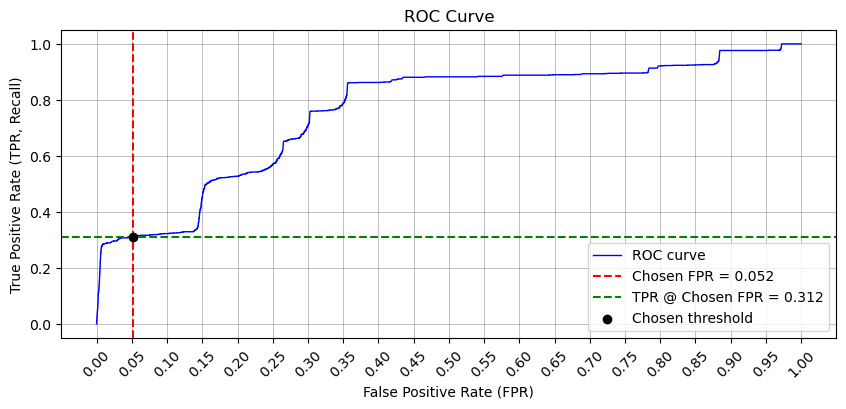

In [63]:
# Plot ROC curve

import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 4))
plt.plot(fpr, tpr, label='ROC curve', color='blue', linewidth=1)
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR, Recall)')
plt.title('ROC Curve')
plt.grid(which='major', linestyle='-', linewidth='0.5', color='gray', alpha=0.7)
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='gray', alpha=0.3)

# Set x-axis ticks with step 0.05
x_ticks = np.arange(0, 1.01, 0.05)
plt.xticks(x_ticks, rotation=45)

# Plot vertical line at CHOSEN_FPR
plt.axvline(x=FINAL_FPR, color='red', linestyle='--', label=f'Chosen FPR = {FINAL_FPR:.3f}')

# Plot horizontal line at corresponding TPR - USE FINAL_TPR instead of tpr[idx]
plt.axhline(y=FINAL_TPR, color='green', linestyle='--', label=f'TPR @ Chosen FPR = {FINAL_TPR:.3f}')

# Mark the chosen point
plt.scatter([FINAL_FPR], [FINAL_TPR], color='black', zorder=5, label='Chosen threshold')

plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [64]:
# Make predictions at chosen threshold on pairwise_df

pairwise_df['prediction'] = (pairwise_df['siam_l2_dist'] <= FINAL_THR).astype(int)

# Optionally, print value counts for sanity check
print(f"Prediction value counts at FPR={FINAL_FPR}:")
print(pairwise_df['prediction'].value_counts().to_frame())

Prediction value counts at FPR=0.05175701940888228:
             count
prediction        
0           104734
1             6046


Test set metrics at FPR=0.05175701940888228:
Accuracy:  0.9414
Precision: 0.0614
Recall:    0.3115
F1 Score:  0.1025


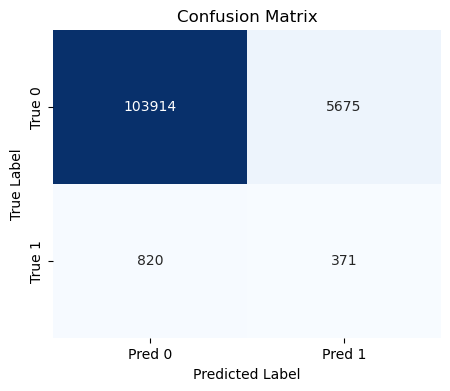


Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.95      0.97    109589
           1       0.06      0.31      0.10      1191

    accuracy                           0.94    110780
   macro avg       0.53      0.63      0.54    110780
weighted avg       0.98      0.94      0.96    110780



In [65]:
# Compute metrics on test set
# Assume pairwise_df has columns: 'label' (ground truth), 'prediction' (predicted)
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

y_true = pairwise_df['label']
y_pred = pairwise_df['prediction']

acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, zero_division=0)
rec = recall_score(y_true, y_pred, zero_division=0)
f1 = f1_score(y_true, y_pred, zero_division=0)
cm = confusion_matrix(y_true, y_pred)

print(f"Test set metrics at FPR={FINAL_FPR}:")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 Score:  {f1:.4f}")

# Better confusion matrix visualization using seaborn
plt.figure(figsize=(5,4))
sns.heatmap(
    cm, annot=True, fmt='d', cmap='Blues', cbar=False,
    xticklabels=['Pred 0', 'Pred 1'], yticklabels=['True 0', 'True 1']
)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

print("\nClassification Report:")
print(classification_report(y_true, y_pred, zero_division=0))

In [66]:
# save predictions w/ metrics as metadata

import pyarrow as pa
import pyarrow.parquet as pq

save_folder_path = Path(PAIRWISE_MAPPING_FILE_NAME).parent
save_file_path = save_folder_path / f'preds_fpr={FINAL_FPR}.parquet'
print(f"Saving predictions to:\n{save_file_path}")
save_file_path = Path(DATA_PATH) / save_file_path
save_file_path.parent.mkdir(parents=True, exist_ok=True)

meta = {
    "chosen_fpr": round(float(FINAL_FPR), 3),
    "tpr": round(float(FINAL_TPR), 3),
    "threshold": round(float(FINAL_THR), 3),
    "accuracy": round(float(acc), 3),
    "precision": round(float(prec), 3),
    "recall": round(float(rec), 3),
}

# Convert DataFrame to PyArrow Table
table = pa.Table.from_pandas(pairwise_df)

# Convert metadata values to strings (required for PyArrow metadata)
metadata_strings = {key: str(value) for key, value in meta.items()}

# Add custom metadata to the schema
table = table.replace_schema_metadata(metadata_strings)

# Write with PyArrow
pq.write_table(table, save_file_path)

print(f"\nSaved predictions with metadata:\n{meta}")

Saving predictions to:
tables_OZ_geo_5500/processed/regex-pairwise-groups/regex-pairwise-groups_num-queries=20_patterns-dict-hash=a6223255f273e52a893ba7235e3c19b3/preds_fpr=0.05175701940888228.parquet

Saved predictions with metadata:
{'chosen_fpr': 0.052, 'tpr': 0.312, 'threshold': 1.01, 'accuracy': 0.941, 'precision': 0.061, 'recall': 0.312}
